# Metis Solar Wind Speed Calculator from UV and pB maps

This notebook implements the Doppler Dimming Technique (DDT) to evaluate Solar Wind Speed in the Solar Corona.

The ultraviolet (UV) and polarized Brightness ($pB$) maps are derived from the [Metis](https://metis.oato.inaf.it/index.html) coronagraph onboard the [Solar Orbiter](https://www.esa.int/Science_Exploration/Space_Science/Solar_Orbiter) spacecraft.

- Author: Dario Vetrano
- Date: August 2025
- Contact: dario.vetrano@studenti.polito.it

---

## Project Overview

This notebook contains a Python implementation for deriving 2D solar wind outflow velocity maps from coronagraphic observations using the Doppler Dimming Technique (DDT). The primary objective is to synthesize the resonantly scattered H I Ly-α line intensity and iteratively match it with observational data to map plasma outflow speeds in the inner heliosphere.

## Methodology

The solar wind speed is derived via the following computational pipeline:

1.  **Electron Density ($n_e$) Inversion**: Coronal electron density maps are derived from VL polarized brightness (pB) images using the Van de Hulst inversion technique.
2.  **H I Ly-α Intensity Synthesis**: The theoretical intensity of the resonantly scattered H I Ly-α line is calculated by integrating the local emissivity along the line of sight (LOS).
3.  **Doppler Dimming Analysis**: The outflow velocity ($V_w$) is determined by iteratively adjusting its value in the synthetic model. The final velocity is the one that minimizes the difference between the calculated and observed UV Ly-α intensities, accounting for the Doppler dimming effect.

## Physical Model and Key Assumptions

The accuracy of the derived velocity map is fundamentally dependent on the physical assumptions used to model the coronal environment.

* **Chromospheric Illumination**: Assumes a **uniform** Ly-α brightness over the solar disk. 
* **Electron Temperature ($T_e$)**: Implements the hydrostatic temperature profile from **Gibson et al. (1999)** to determine the ionization equilibrium of hydrogen.
* **HI Kinetic Temperature ($T_{HI}$)**: Assumes a **constant and isotropic** kinetic temperature for neutral hydrogen atoms. This does not account for known variations with heliocentric distance or potential anisotropy ($T_{\perp} \neq T_{||}$).
* **Ionization Equilibrium**: Utilizes the **ChiantiPy** library, accessing the CHIANTI atomic database, to calculate the neutral hydrogen fraction ($R_i$) as a function of the local electron temperature.

## Two-Step Refinement Process

A two-step iterative procedure is implemented to account for the variation of $V_w$ along $x_{\text{LOS}}$:

1.  **Initial Map Calculation**: An approximate velocity map is computed assuming a constant outflow velocity along each line of sight.
2.  **Refined Map Calculation**: The initial map is used to construct a 3D coronal model where velocity is a function of heliocentric distance ($V_{model}(r)$). The calculation is then repeated, using this more realistic, radially increasing velocity profile along the LOS to determine a refined velocity map.

## References

This work is based on the methods and models described in the following publications:

* Giordano, S., et al. (2025), *Solar wind speed maps from the Metis coronagraph observations*
* Dolei, S., et al. (2019), *Effect of the non-uniform solar chromospheric Lya radiation on determining the coronal HI outflow velocity*
* Dolei, S., et al. (2018), *Mapping the solar wind HI outflow velocity in the inner heliosphere*
* Auchère, F. (2005), *Effect of the H I Lyα Chromospheric Flux Anisotropy on the Total Intensity of the Resonantly Scattered Coronal Radiation*
* Gibson, S. E., et al. (1999), *Solar minimum streamer densities and temperatures using Whole Sun Month coordinated data sets*

# Notebook Initialization and Environment Setup

This section imports all necessary Python libraries, configures the computational environment, and loads the local modules containing the core scientific functions for the analysis.

In [99]:
# =============================================================================
#  1. CORE LIBRARIES 
# =============================================================================
import os
import sys
import platform
import time
import warnings
from pathlib import Path
from datetime import datetime
from os.path import basename

# =============================================================================
#  2. SCIENTIFIC COMPUTING LIBRARIES
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter

from matplotlib import cm
from scipy.optimize import brentq, curve_fit, least_squares
from scipy.interpolate import interp1d
from scipy import ndimage

# =============================================================================
#  3. ASTRONOMY & ASTROPHYSICS LIBRARIES
# =============================================================================
import astropy.units as u
from astropy.io import fits
from astropy.wcs import FITSFixedWarning, WCS
from astropy.io.fits.verify import VerifyWarning
import sunpy.map
from sunpy.sun import constants

# --- CHIANTI Atomic Database Setup ---
# ChiantiPy requires the $XUVTOP environment variable to point to the database location.
# This section sets the path programmatically.

# First, ensure the HOME variable is set, which is sometimes needed for Windows users
if 'HOME' not in os.environ and platform.system() == 'Windows':
    os.environ['HOME'] = os.path.expanduser('~')

# !!! IMPORTANT !!!
# You must replace the path below with the location of the CHIANTI database on your computer.
# xuvtop_path = r'C:\PATH\TO\YOUR\CHIANTI_11.0.2_database'
xuvtop_path = r'C:\Users\Lenovo1\Desktop\CORONA HYDRODYNAMIC STABILITY\Doppler Dimming Technique\codice\CHIANTI_DB\CHIANTI_11.0.2_database' 
os.environ['XUVTOP'] = xuvtop_path

import ChiantiPy.core as ch

# =============================================================================
#  4. JUPYTER NOTEBOOK & UTILITY LIBRARIES
# =============================================================================
from IPython.display import clear_output

# =============================================================================
#  5. LOCAL MODULES & CUSTOM FUNCTIONS
# =============================================================================
from aux_lib_lyman_alpha import get_Gibson_temperature, precompute_los_arrays, precompute_los_arrays_II, integrate_intensity_los_numba
from metis_aux_lib import calc_el_dens_and_K, polar_to_cart, align_polar_maps, fit_negative_power_series, cut_metis_fov, cart_to_polar, sqrt_model

# =============================================================================
#  6. ENVIRONMENT CONFIGURATION
# =============================================================================
# Suppress a common, often benign, warning from Astropy when reading FITS headers
warnings.filterwarnings('ignore', category=FITSFixedWarning)
warnings.simplefilter('ignore', category=VerifyWarning)

# =============================================================================
#  7. JUPYTER MAGIC COMMANDS
# =============================================================================
%reload_ext autoreload
%autoreload 2

# Data Loading and Preprocessing

This section defines the paths to the observational data, loads the UV and VL FITS files, and matches them based on the closest acquisition time to create analysis-ready `sunpy` Map objects.

In [28]:
# ---------------- SETTINGS ----------------
folder_path_1 = Path('./UV_IMAGES')
folder_path_2 = Path('./VL_IMAGES/')

# ---------------- HELPER ----------------
def extract_datetime_from_filename(fname):
    """Extract datetime object from filename containing YYYYMMDDTHHMMSS."""
    parts = fname.split("_")
    for part in parts:
        if "T" in part and len(part) >= 15:  # crude check
            try:
                return datetime.strptime(part, "%Y%m%dT%H%M%S")
            except ValueError:
                pass
    raise ValueError(f"Could not parse date from: {fname}")

# ---------------- LOAD FILE LISTS ----------------
L2_files_UV = [f for f in folder_path_1.iterdir() if f.is_file()]
L2_files_VL = [f for f in folder_path_2.iterdir() if f.is_file()]

# Parse dates
UV_with_dates = [(path, extract_datetime_from_filename(path.name)) for path in L2_files_UV]
VL_with_dates = [(path, extract_datetime_from_filename(path.name)) for path in L2_files_VL]

# ---------------- MATCHING ----------------
matches = []
for uv_path, uv_date in UV_with_dates:
    closest_vl_path, closest_vl_date = min(
        VL_with_dates,
        key=lambda x: abs((x[1] - uv_date).total_seconds())
    )
    matches.append((uv_path, closest_vl_path))

# ---------------- PROCESS EACH MATCH ----------------

# for path_UV, path_VL in matches[1]:

path_UV, path_VL = matches[1]

print(f"\nProcessing:\nUV: {path_UV}\nVL: {path_VL}")

fits_pb = fits.open(path_VL)[0]
fits_uv = fits.open(path_UV)[0] 

fits_pb.header['RSUN_OBS'] = fits_pb.header['RSUN_ARC']
fits_uv.header['RSUN_OBS'] = fits_uv.header['RSUN_ARC']

wcs_pb = WCS(fits_pb.header)
wcs_uv = WCS(fits_uv.header)

map_pb = sunpy.map.Map(fits_pb.data, fits_pb.header)
map_uv = sunpy.map.Map(fits_uv.data, fits_uv.header)

print("If nothing strange shows up (inf, nan, 0 ...), data has been correctly retrieved:",
      np.mean(fits_pb.data) / np.mean(fits_uv.data))

cut_metis_fov(fits_pb)
cut_metis_fov(fits_uv)

METIS_VL_CMAP = plt.colormaps["plasma"].copy()
METIS_VL_CMAP.set_bad(color='tab:gray') 

METIS_UV_CMAP = plt.colormaps["RdYlBu_r"].copy()
METIS_UV_CMAP.set_bad(color='tab:gray') 

date_pb = fits_pb.header["DATE-OBS"]
date_uv = fits_uv.header["DATE-OBS"]

rsun_pix_uv = fits_uv.header['RSUN_ARC']/fits_uv.header['CDELT1'] 
rsun_pix_pb = fits_pb.header['RSUN_ARC']/fits_pb.header['CDELT1'] 


print(f"VL DATE-OBS: {date_pb} | UV DATE-OBS: {date_uv}")


Processing:
UV: UV_IMAGES\solo_L2_metis-uv-image_20220915T224012_V01.fits
VL: VL_IMAGES\solo_L2_metis-vl-pb_20220915T223500_V01.fits
If nothing strange shows up (inf, nan, 0 ...), data has been correctly retrieved: 5.696707e-20
VL DATE-OBS: 2022-09-15T22:35:00.983 | UV DATE-OBS: 2022-09-15T22:40:12.252


# Coordinate System Transformation

This section transforms the observational data from Cartesian (x, y) to polar (r, φ) coordinates. The `cart_to_polar` utility function is applied to both the UV and pB FITS data, creating new arrays where the data is organized radially. The resulting radial coordinates are then scaled from pixels to solar radii ($R_{\odot}$).

In [70]:
polar_uv, r_matrix_uv_pix, r_arr_uv, rsun_pix_uv, phi_arr_uv = cart_to_polar(fits_uv, dr = rsun_pix_uv / 100, dphi = 1, rot_angle=None, cval=np.nan, cut_out_fov = 50, cut_in_fov = 0)

polar_uv = np.where(polar_uv > 0, polar_uv, np.nan)

r_matrix_uv = r_matrix_uv_pix / rsun_pix_uv
r_arr_uv = r_arr_uv / rsun_pix_uv

polar_pb, r_matrix_pb_pix, r_arr_pb, rsun_pix_pb, phi_arr_pb = cart_to_polar(fits_pb, dr = rsun_pix_pb / 100, dphi = 1, cval=np.nan, cut_out_fov = 0, cut_in_fov = 5)

r_matrix_pb = r_matrix_pb_pix / rsun_pix_pb
r_arr_pb = r_arr_pb / rsun_pix_pb

# Electron Density Inversion

This section derives the coronal electron density ($n_e$) map by applying the Van de Hulst inversion to the polar pB data. The resulting density map is then masked to preserve regions with no valid data from the original observations.

In [87]:
polar_ne, _ = calc_el_dens_and_K(polar_pb, r_arr_pb)

polar_ne = np.where(~np.isnan(polar_pb), polar_ne, np.nan)
polar_ne = np.where(polar_ne > 0, polar_ne, np.nan)


calc_binvertdata:
 - x = (3.660288723810256-7.503614891532754, dx=0.010)
 - k = [1, 2, 3, 4]
 - q = 0.63 
..................................................................................................................................................................................................................................................................................................................................................................................................Done


# Data Resampling and Alignment

This section resamples the UV and $n_e$ polar maps onto a common radial grid to ensure they are spatially aligned for subsequent analysis.

In [88]:
polar_uv_resam, polar_ne_resam, r_matrix, r_common = align_polar_maps(polar_uv, r_matrix_uv, r_arr_uv, polar_ne, r_matrix_pb, r_arr_pb)

--- Aligning Polar Maps ---
Original A shape: (147, 360), Original B shape: (385, 360)
Resampled A shape: (134, 360), Resampled B shape: (134, 360)
New common grid created with 134 radial steps from 3.66 R☉ to 5.00 R☉.
--- Alignment Complete ---


# Data Visualization


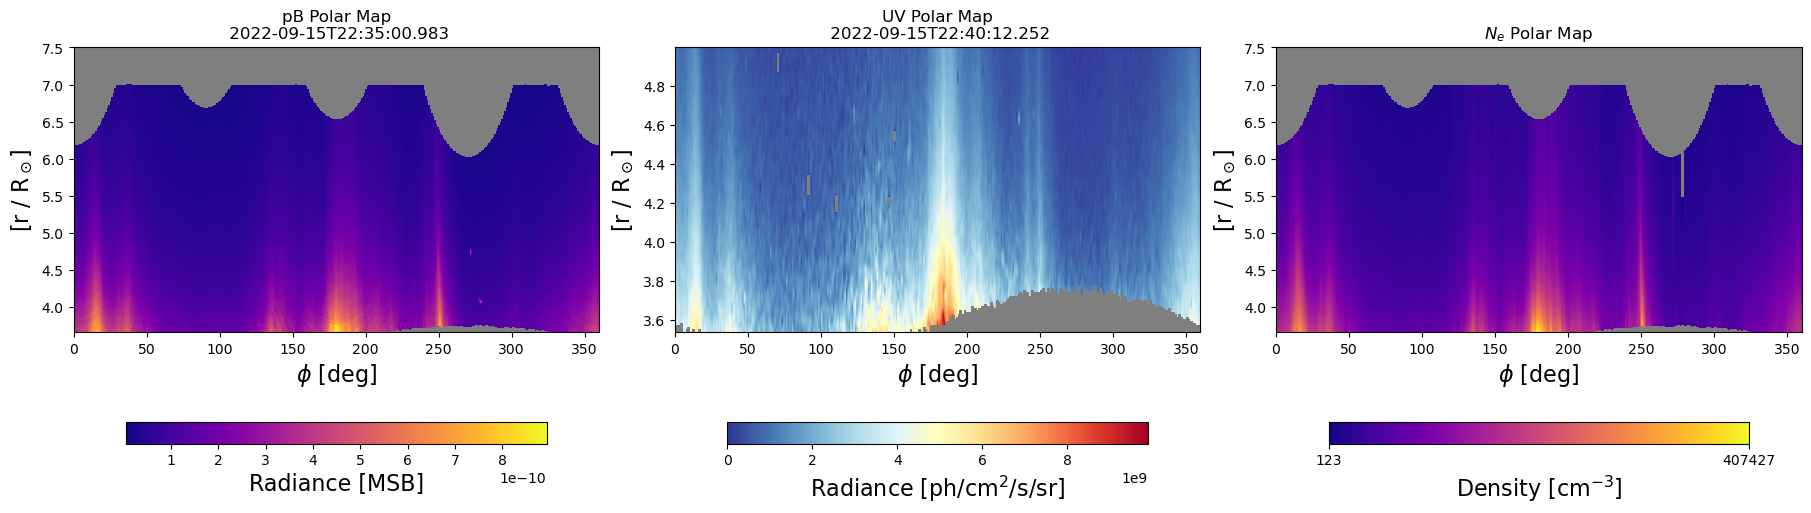

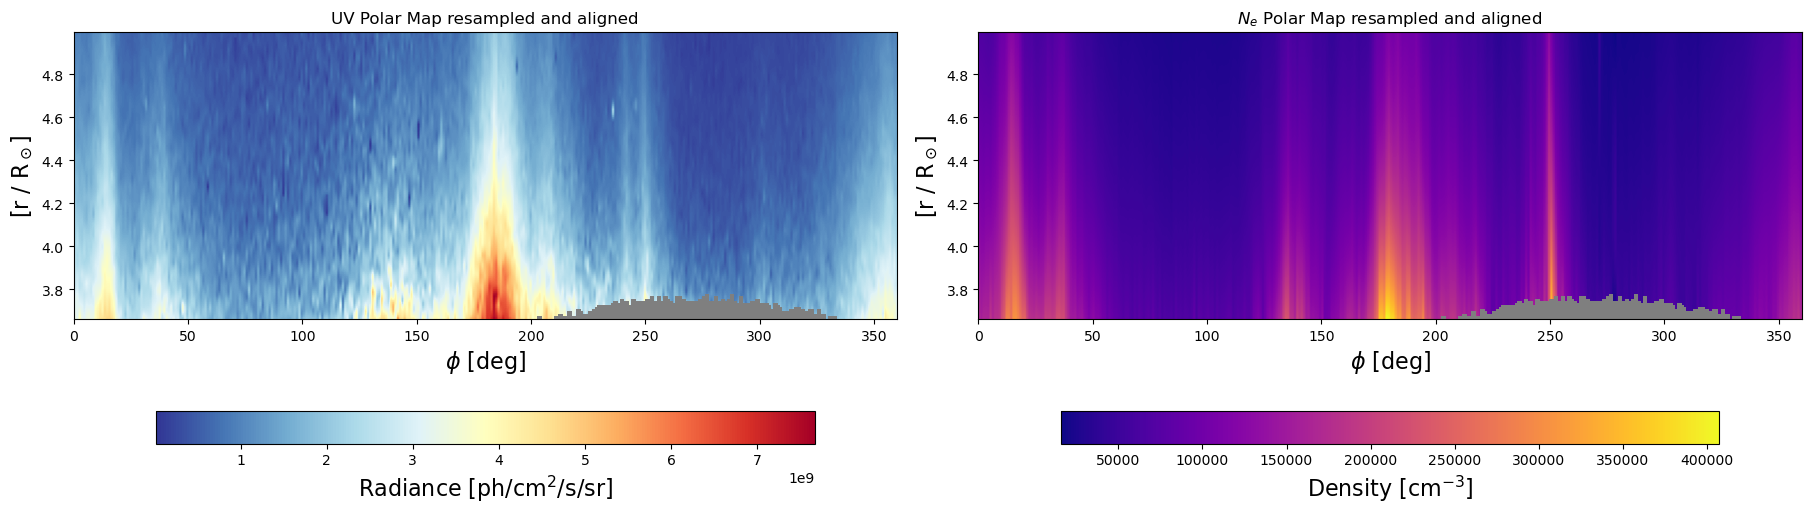

In [96]:
# PLOT

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# # Plot PB
im_pb = axes[0].imshow(polar_pb, cmap=METIS_VL_CMAP, origin="lower", extent=[0, polar_pb.shape[1], r_arr_pb[0], r_arr_pb[-1]], aspect = 'auto')
axes[0].set_title(f"pB Polar Map\n {date_pb}", fontsize=12)
cbar_pb = plt.colorbar(im_pb, ax=axes[0], orientation='horizontal', pad=0.1, shrink=0.8)
cbar_pb.set_label("Radiance [MSB]")
axes[0].set_ylabel("[r / R$_\\odot$]")
axes[0].set_xlabel("$\phi$ [deg]")

# Plot UV
im_uv = axes[1].imshow(polar_uv, cmap=METIS_UV_CMAP, origin="lower", extent=[0, polar_uv.shape[1], r_arr_uv[0], r_arr_uv[-1]], aspect = 'auto', vmin = 0)
axes[1].set_title(f"UV Polar Map\n {date_uv}", fontsize=12)
cbar_uv = plt.colorbar(im_uv, ax=axes[1], orientation='horizontal', pad=0.1, shrink=0.8)
cbar_uv.set_label("Radiance [ph/cm$^2$/s/sr]")
axes[1].set_ylabel("[r / R$_\\odot$]")
axes[1].set_xlabel("$\phi$ [deg]")

# Plot ne
im_ne = axes[2].imshow(polar_ne, cmap=METIS_VL_CMAP, origin="lower", extent=[0, polar_ne.shape[1], r_arr_pb[0], r_arr_pb[-1]], aspect = 'auto')
axes[2].set_title(f"$N_e$ Polar Map", fontsize=12)
cbar_ne = plt.colorbar(im_ne, ax=axes[2], orientation='horizontal', pad=0.1, shrink=0.8)
cbar_ne.set_label("Density [cm$^{-3}$]")
axes[2].set_ylabel("[r / R$_\\odot$]")
axes[2].set_xlabel("$\phi$ [deg]")

tick_positions = [np.nanmin(polar_ne), np.nanmax(polar_ne)] 
cbar_ne.set_ticks(tick_positions)

plt.show()


fig, axes = plt.subplots(1, 2, figsize=(18, 5), constrained_layout=True)

# Plot UV resampled and aligned
im_uv = axes[0].imshow(polar_uv_resam, cmap=METIS_UV_CMAP, origin="lower", extent=[0, polar_uv.shape[1], r_common[0], r_common[-1]], aspect = 'auto')
axes[0].set_title("UV Polar Map resampled and aligned", fontsize=12)
cbar_uv = plt.colorbar(im_uv, ax=axes[0], orientation='horizontal', pad=0.1, shrink=0.8)
cbar_uv.set_label("Radiance [ph/cm$^2$/s/sr]")
axes[0].set_ylabel("[r / R$_\\odot$]")
axes[0].set_xlabel("$\phi$ [deg]")

# Plot ne resampled and aligned
im_ne = axes[1].imshow(polar_ne_resam, cmap=METIS_VL_CMAP, origin="lower", extent=[0, polar_ne.shape[1], r_common[0], r_common[-1]], aspect = 'auto')
axes[1].set_title("$N_e$ Polar Map resampled and aligned", fontsize=12)
cbar_ne = plt.colorbar(im_ne, ax=axes[1], orientation='horizontal', pad=0.1, shrink=0.8)
cbar_ne.set_label("Density [cm$^{-3}$]")
axes[1].set_ylabel("[r / R$_\\odot$]")
axes[1].set_xlabel("$\phi$ [deg]")

plt.show()

## Solar Wind Velocity Calculation via Doppler Dimming (Step I: $V_w = const.$ along LOS)
This cell iterates through each pixel of the polar-coordinate coronal image, using a numerical solver (`brentq`) to determine the solar wind outflow velocity that makes the theoretically synthesized Lyman-alpha line intensity match the observed value.

In [40]:
"""
- Since now polar_ne and polar_uv (more precisely, their resampled versions) have the same shape, we could use both: by convention, we will refer to polar_ne
""" 
"""
- Adjust angle_ROI to select the desired radial(s). In the Cartesian image, the angle
  is defined as zero when pointing east and increases positively in the counterclockwise (CCW) direction.
"""

angle_ROI = np.r_[0:360] # [deg] 

"""
"""

params = {'1': {'a': 1.878, 'delta_lambda': 0.001859e-7, 'sigma': 0.03075e-7},
          '2': {'a': -1.188, 'delta_lambda': 0.002087e-7, 'sigma': 0.02390e-7},
          '3': {'a': 0.31017, 'delta_lambda': 0.002159e-7, 'sigma': 0.07353e-7}}

    
p_a = np.array([p['a'] for p in params.values()])
p_delta_lambda = np.array([p['delta_lambda'] for p in params.values()])
p_sigma = np.array([p['sigma'] for p in params.values()])

velocity_map_kms_I = np.zeros_like(polar_ne_resam)

r_matrix_ROI = r_matrix[:, angle_ROI]  # [Rsun]

total_pixels = np.sum(~np.isnan(r_matrix_ROI))

current_pixel = 0

for i, angle in enumerate(angle_ROI):
    r_arr = r_matrix[:, angle][~np.isnan(polar_ne_resam[:, angle])]
    radial_ne = polar_ne_resam[~np.isnan(polar_ne_resam[:, angle]), angle]

    model_ne, coeffs = fit_negative_power_series(r_arr, radial_ne, degree=3)
    radial_interp_ne = model_ne

    # radial_interp_ne = interp1d(r_arr, radial_ne, kind='linear', fill_value="extrapolate")
    r_max = r_arr[-1] # To set the integration bounds along the LOS
    
    clear_output(wait=True)
    print(f"Processing angle: {i+1} / {len(angle_ROI)}")
    print(f"{current_pixel} / {total_pixels} pixels processed ({current_pixel / total_pixels * 100:.2f} % completed)")
    
    for j, r_pos in enumerate(r_arr):
        
        current_pixel += 1

        I_obs = polar_uv_resam[j, angle]

        if np.isnan(I_obs):
            velocity_map_kms_I[j, angle] = np.nan
            print("I_obs is NaN")
            continue
            
        r_3d, n_e_arr, Ri_arr, beta_arr, x_cm, theta_mat = precompute_los_arrays(r_pos, radial_interp_ne, r_max)

        # print( r_3d, n_e_arr, Ri_arr, beta_arr, x_cm)
        
        I_static = integrate_intensity_los_numba(0, n_e_arr, Ri_arr, beta_arr, theta_mat, x_cm, p_a, p_delta_lambda, p_sigma)
        
        # print(f" --- I_static: {I_static:.2e}, I_observed: {I_obs:.2e} ---")
           
        def objective_function(vw_kms):
          return integrate_intensity_los_numba(vw_kms, n_e_arr, Ri_arr, beta_arr, theta_mat, x_cm, p_a, p_delta_lambda, p_sigma) - I_obs

        if I_static <= I_obs:  

            if np.isclose(I_static, I_obs, rtol=5e-2):
                velocity_map_kms_I[j, angle] = 0
                # print("ΔI < 5% => Vw set to 0 km/s")
                continue
            else:
                velocity_map_kms_I[j, angle] = np.nan
                # print("I_obs < I_static => Vw set to NaN")
                continue

        else:
            try:
                found_velocity = brentq(objective_function, a=1, b=500, rtol=0.01)
                velocity_map_kms_I[j, angle] = found_velocity
                
            except ValueError:
                velocity_map_kms_I[j, angle] = np.nan
                print("Value Error in brentq")
                
clear_output(wait = True)
print(f"Velocity map computation completed for {current_pixel} pixel.")

Velocity map computation completed for 47540 pixel.


In [41]:
# np.save(f"vw_map_step_1_sqrt_{date_pb.replace(':', '')}.npy", velocity_map_kms_I)

velocity_map_kms_I = np.load('vw_map_step_1_sqrt_{date_pb.replace(':', '')}.npy')

## Solar Wind Velocity Calculation via Doppler Dimming (Step II: $V_w = f(x_{\text{LOS}}$) ) 

This cell performs the second, refined stage of the two-step iterative process to calculate the map of the solar wind outflow velocity, using the pre-computed velocity map to build a more physically realistic 3D model of the corona.

In [44]:
angle_ROI = np.r_[0:360] # [deg] 

velocity_map_kms_II = np.zeros_like(polar_ne_resam)

r_matrix_ROI = r_matrix[:, angle_ROI]  # [Rsun]

total_pixels = np.sum(~np.isnan(r_matrix_ROI))

current_pixel = 0

for i, angle in enumerate(angle_ROI):
    r_arr_ne = r_matrix[~np.isnan(polar_ne_resam[:, angle]), angle]
    radial_ne = polar_ne_resam[~np.isnan(polar_ne_resam[:, angle]), angle]
    model, coeffs = fit_negative_power_series(r_arr_ne, radial_ne, degree=3)
    radial_interp_ne = model
    
    mask_Vw = ~np.isnan(velocity_map_kms_I[:, angle]) & ~np.isnan(r_matrix[:, angle])
    r_arr_Vw = r_matrix[mask_Vw, angle]
    radial_Vw = velocity_map_kms_I[mask_Vw, angle]

    """
    interp1d:
    """
    # radial_interp_Vw = interp1d(r_arr_Vw, radial_Vw, kind='linear', fill_value="extrapolate")
    """
    Linear LSQ fit:
    """
    # m, q = np.polyfit(r_arr_Vw, radial_Vw, deg=1)  # deg=1 = retta
    # radial_interp_Vw = lambda x: m * x + q
    """
    sqrt model:
    """

    popt, _ = curve_fit(sqrt_model, r_arr_Vw, radial_Vw, p0=[10, 0], bounds=([-np.inf, 0], [np.inf, np.inf]))
    a, b = popt
    radial_interp_Vw = lambda x: a + b * np.sqrt(x)

    r_max = r_arr_Vw[-1] # To set the integration bounds along the LOS
    
    clear_output(wait=True)
    print(f"Processing angle: {i+1} / {len(angle_ROI)}")
    print(f"{current_pixel} / {total_pixels} pixels processed ({current_pixel / total_pixels * 100:.2f} % completed)")
    
    for j, r_pos in enumerate(r_arr_Vw):
        
        current_pixel += 1

        I_obs = polar_uv_resam[j, angle]

        if np.isnan(I_obs):
            velocity_map_kms_II[j, angle] = np.nan
            print("I_obs is NaN")
            continue
 
        r_los, n_e_los, Vw_los, Ri_los, beta_los, theta_mat, x_cm = precompute_los_arrays_II(r_pos, radial_interp_ne, radial_interp_Vw, r_max)
        
        def objective_function(Vw_pos_kms):

            """
            Now we pass a scaled Velocity profile to I_synthetic: the objective is to find the Vw on the POS able to minimize ΔI 
            """
            
            scaled_Vw_profile = Vw_pos_kms * Vw_los / radial_interp_Vw(r_pos)
            return integrate_intensity_los_numba(scaled_Vw_profile, n_e_arr, Ri_arr, beta_arr, theta_mat, x_cm, p_a, p_delta_lambda, p_sigma) - I_obs

        try:

            found_velocity = brentq(objective_function, a=0, b=500, rtol=0.01)
    
            # print(f"Found_velocity: {found_velocity:.2f} km/s")    
            
            velocity_map_kms_II[j, angle] = found_velocity
            
        except ValueError:
            velocity_map_kms_II[j, angle] = 0
            print("Value Error in brentq")

clear_output(wait = True)
print(f"Velocity map computation completed for {current_pixel} pixel.")

Velocity map computation completed for 47504 pixel.


In [49]:
# np.save(f"vw_map_step_2_sqrt_{date_pb.replace(':', '')}.npy", velocity_map_kms_II)

velocity_map_kms_II = np.load('vw_map_step_2_sqrt_{date_pb.replace(':', '')}.npy')

# Data Visualization

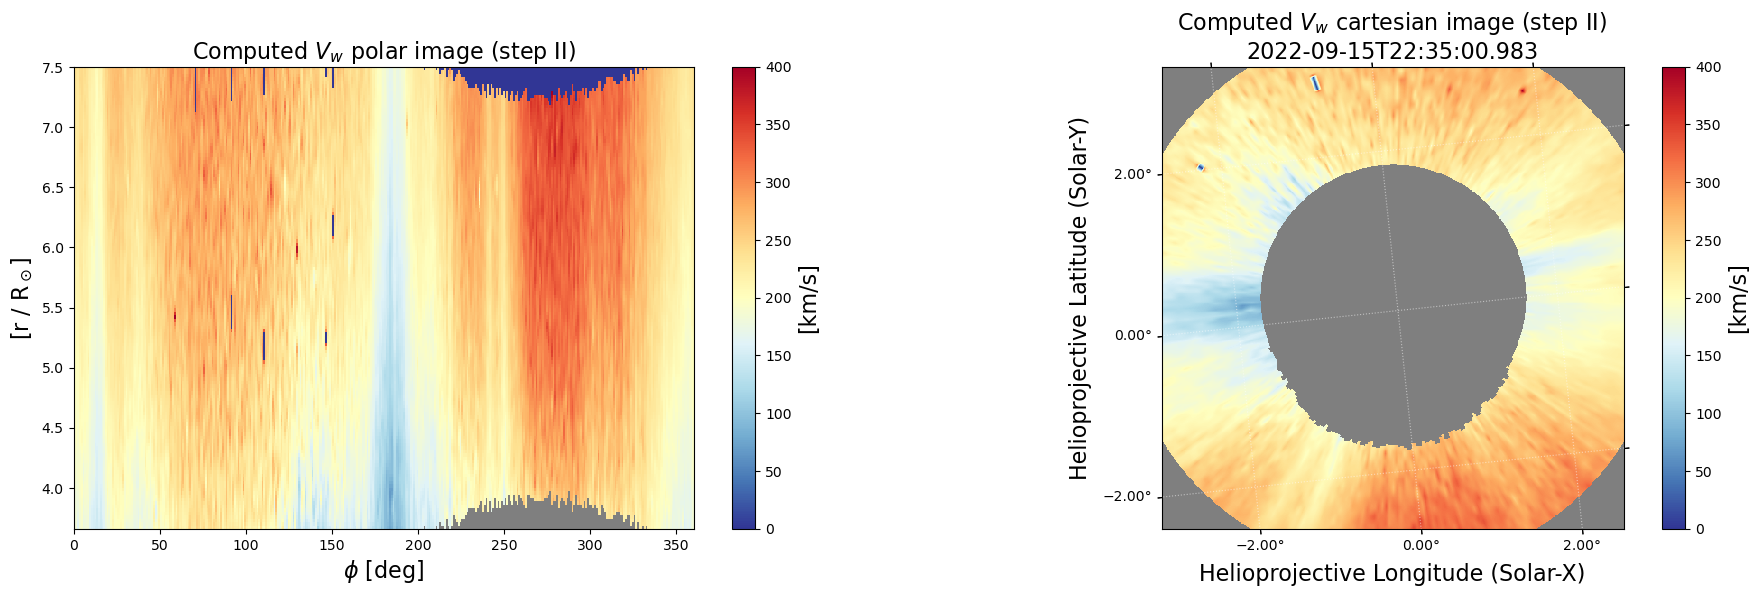

In [125]:
# PLOT
my_cartesian_Vw_II = polar_to_cart(velocity_map_kms_II, (512, 512), 256, 256, rsun_pix_pb, r_arr_pb[0], r_arr_pb[-1], 1 / rsun_pix_uv, rot_angle=None, cut_fov=True)

fig0 = plt.figure(figsize=(22, 6))

ax0 = fig0.add_subplot(1, 2, 1)  
img_Vw_pol0 = ax0.imshow(velocity_map_kms_II, origin='lower', cmap=METIS_UV_CMAP, interpolation='none',  vmin = 0, vmax = 400 , extent=[0, polar_ne.shape[1], r_arr_pb[0] , r_arr_pb[-1] ], aspect = 'auto')
ax0.set_ylabel("[r / R$_\\odot$]")
ax0.set_xlabel("$\phi$ [deg]");

my_cbar_Vw= plt.colorbar(img_Vw_pol0, ax=ax0, label='[km/s]')
ax0.set_title('Computed $V_w$ polar image (step II)');

ax1 = fig0.add_subplot(1, 2, 2, projection=wcs_pb)

img_Vw = ax1.imshow(my_cartesian_Vw_II, origin='lower', cmap=METIS_UV_CMAP,  vmin = 0, vmax = 400, interpolation='none')
cbar_Vw = plt.colorbar(img_Vw, ax=ax1, label='[km/s]')

lon, lat = ax1.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax1.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
ax1.set_xlabel('Helioprojective Longitude (Solar-X)')
ax1.set_ylabel('Helioprojective Latitude (Solar-Y)')
ax1.set_title('Computed $V_w$ cartesian image (step II) \n' + date_pb);

## Visualization of selected radials

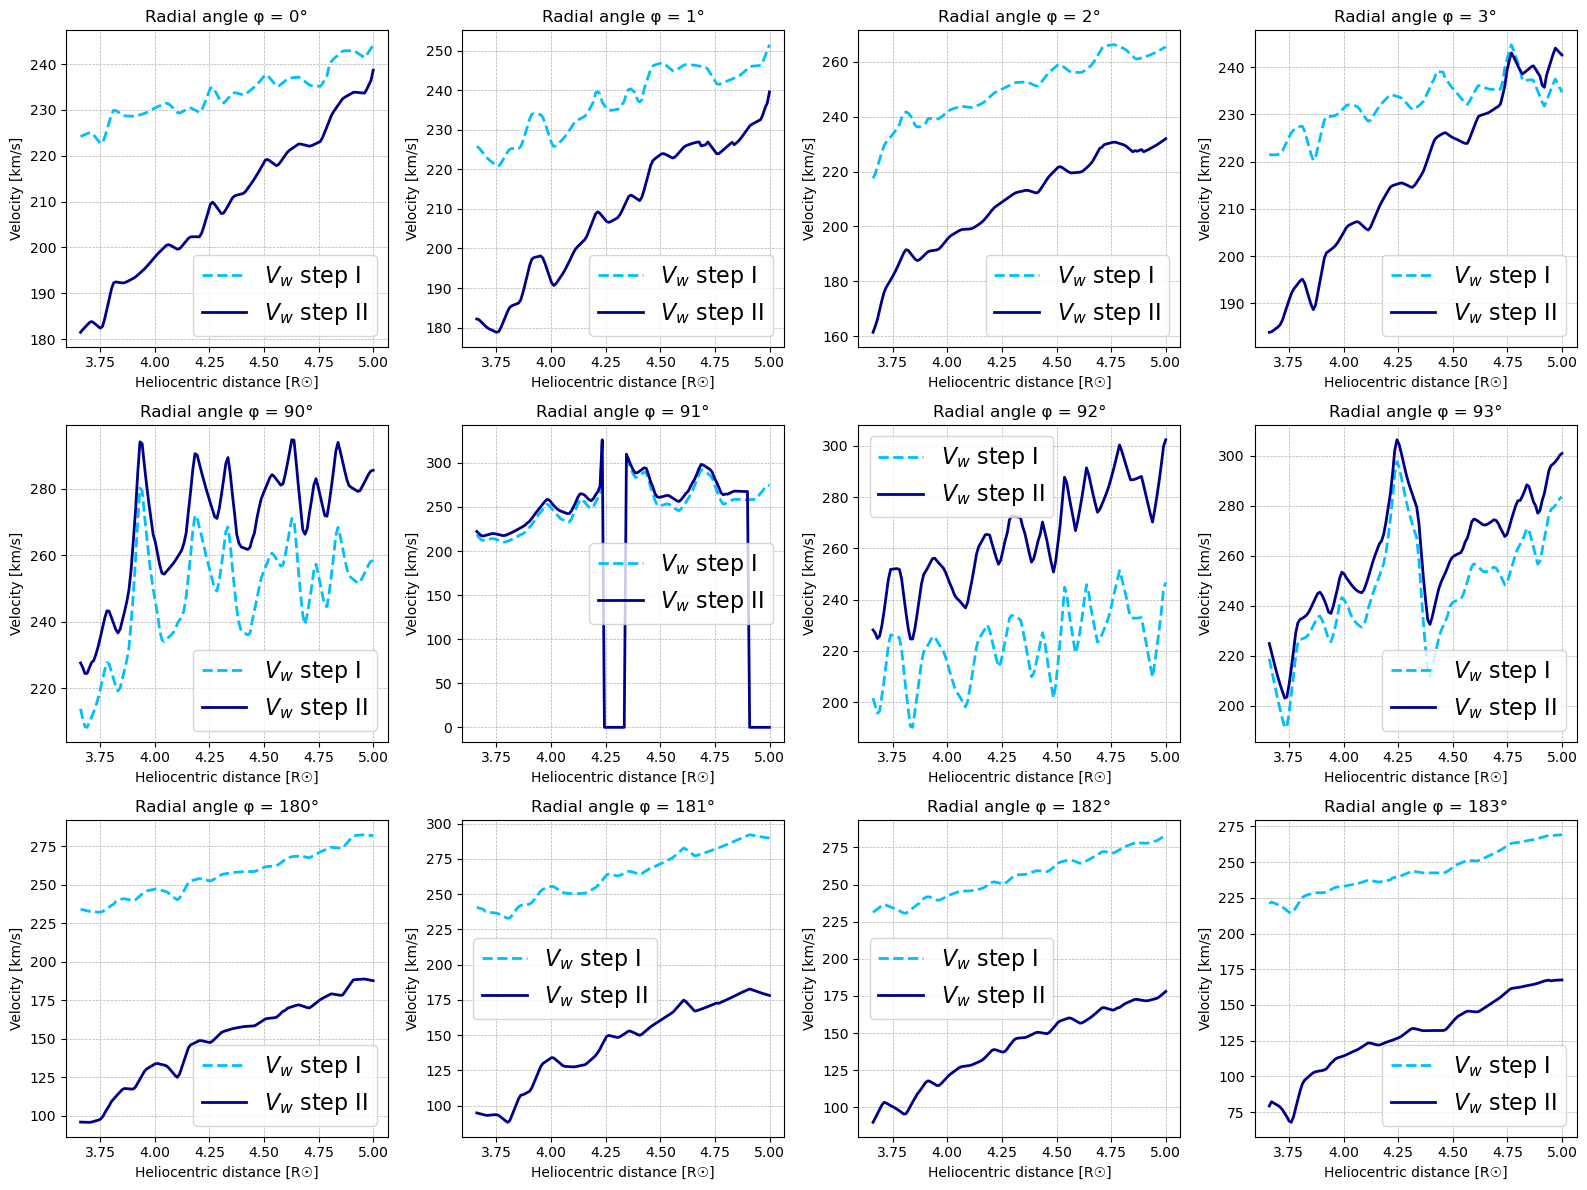

In [124]:
angle_ROI_plot = np.r_[0:4, 90:94, 180:184]  

ncols = 4
nrows = round(np.ceil(len(angle_ROI_plot) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axes = axes.flatten()

for ax, phi_select in zip(axes, angle_ROI_plot):
    r_radial = r_matrix[:, phi_select]
    v_radial_I = velocity_map_kms_I[:, phi_select]
    v_radial_II = velocity_map_kms_II[:, phi_select]
    
    ax.plot(r_radial, v_radial_I, color='deepskyblue', linestyle = '--', linewidth=2)
    ax.plot(r_radial, v_radial_II, color='darkblue', linewidth=2)
    
    ax.set_title(f"Radial angle φ = {phi_select}°", fontsize=12)
    
    ax.set_ylabel("Velocity [km/s]", fontsize=10)
    ax.set_xlabel("Heliocentric distance [R☉]", fontsize=10)

    
    ax.grid(True, which="both", linestyle='--', linewidth=0.5)
    ax.legend(["$V_w$ step I", "$V_w$ step II"])

# Hide the last empty subplot (if any)
for ax in axes[len(angle_ROI_plot):]:
    ax.set_visible(False)

plt.tight_layout()

# plt.savefig('radial_cfr_btw_maps.png')
plt.show()